# Medicaid and Medicare distribution in taxdata

Extreme benefit amounts are present in taxdata but don't seem expected based on [C-TAM documentation](https://docs.google.com/document/d/1OoWr18ZZkXC9jRI3PHkvKncfCK_BGrTez4syXBCMCK8/edit#heading=h.91rtosbtbpbd).

*Data: CPS | Tax year: 2014 | Author: Max Ghenis | Date run: 2018-04-10 *

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.18.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Number of decimals when printing pandas DataFrames.
pd.set_option('precision', 2)

### Utilities

In [6]:
def weight(df, col):
    return df[col] * df.s006

def weighted_sum(df, col):
    return weight(df, col).sum()

def weighted_mean(df, col):
    return weighted_sum(df, col) / df.s006.sum()

## Generate data

In [7]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy(), verbose=False)
# calc.advance_to_year(2018)
calc.calc_all()

In [20]:
BENS = ['snap_ben', 'ssi_ben', 'housing_ben', 'mcaid_ben', 'mcare_ben',
        'tanf_ben', 'vet_ben', 'wic_ben', 'other_ben']

## Preprocessing

In [75]:
tu = calc.dataframe(['s006', 'XTOT'] + BENS)

In [76]:
tu['XTOT_s006'] = weight(tu, 'XTOT')

In [77]:
def dist(df, ben):
    res = df.groupby('pctile_cumsum_' + ben)[ben + '_pp'].mean().reset_index()
    res.columns = ['pctile', 'amount']
    res['ben'] = ben
    return res

In [78]:
dist_list = []
for i in BENS:
    i_pp = i + '_pp'
    tu[i_pp] = tu[i] / tu.XTOT
    # Limit to participants.
    tmp = tu[tu[i] > 0].copy()
    tmp.sort_values(by=i_pp, inplace=True)
    tmp['pct_cumsum_' + i] = tmp.XTOT_s006.cumsum() / tmp.XTOT_s006.sum()
    tmp['pctile_cumsum_' + i] = (100 * tmp['pct_cumsum_' + i]).round()
    dist_list.append(dist(tmp, i))

In [79]:
dist_long = pd.concat(dist_list).reset_index(drop=True)

In [113]:
dist = dist_long.pivot_table(index='pctile', columns='ben')
dist.columns = dist.columns.droplevel()
dist_unindex = dist.copy()
dist_unindex['pctile'] = dist_unindex.index

## Analysis

### Totals

In [87]:
for i in BENS:
    print i + ': $' + str(round(weighted_sum(tu, i) / 1e8) / 10) + 'B'

snap_ben: $82.9B
ssi_ben: $54.0B
housing_ben: $32.6B
mcaid_ben: $368.1B
mcare_ben: $575.2B
tanf_ben: $8.8B
vet_ben: $146.6B
wic_ben: $3.6B
other_ben: $228.4B


### Maxima

In [89]:
for i in BENS:
    print i + ': $' + str(round(tu[i + '_pp'].max()))

snap_ben: $26199.0
ssi_ben: $30274.0
housing_ben: $26610.0
mcaid_ben: $454619.0
mcare_ben: $691961.0
tanf_ben: $17402.0
vet_ben: $140358.0
wic_ben: $2051.0
other_ben: $162980.0


### CDFs

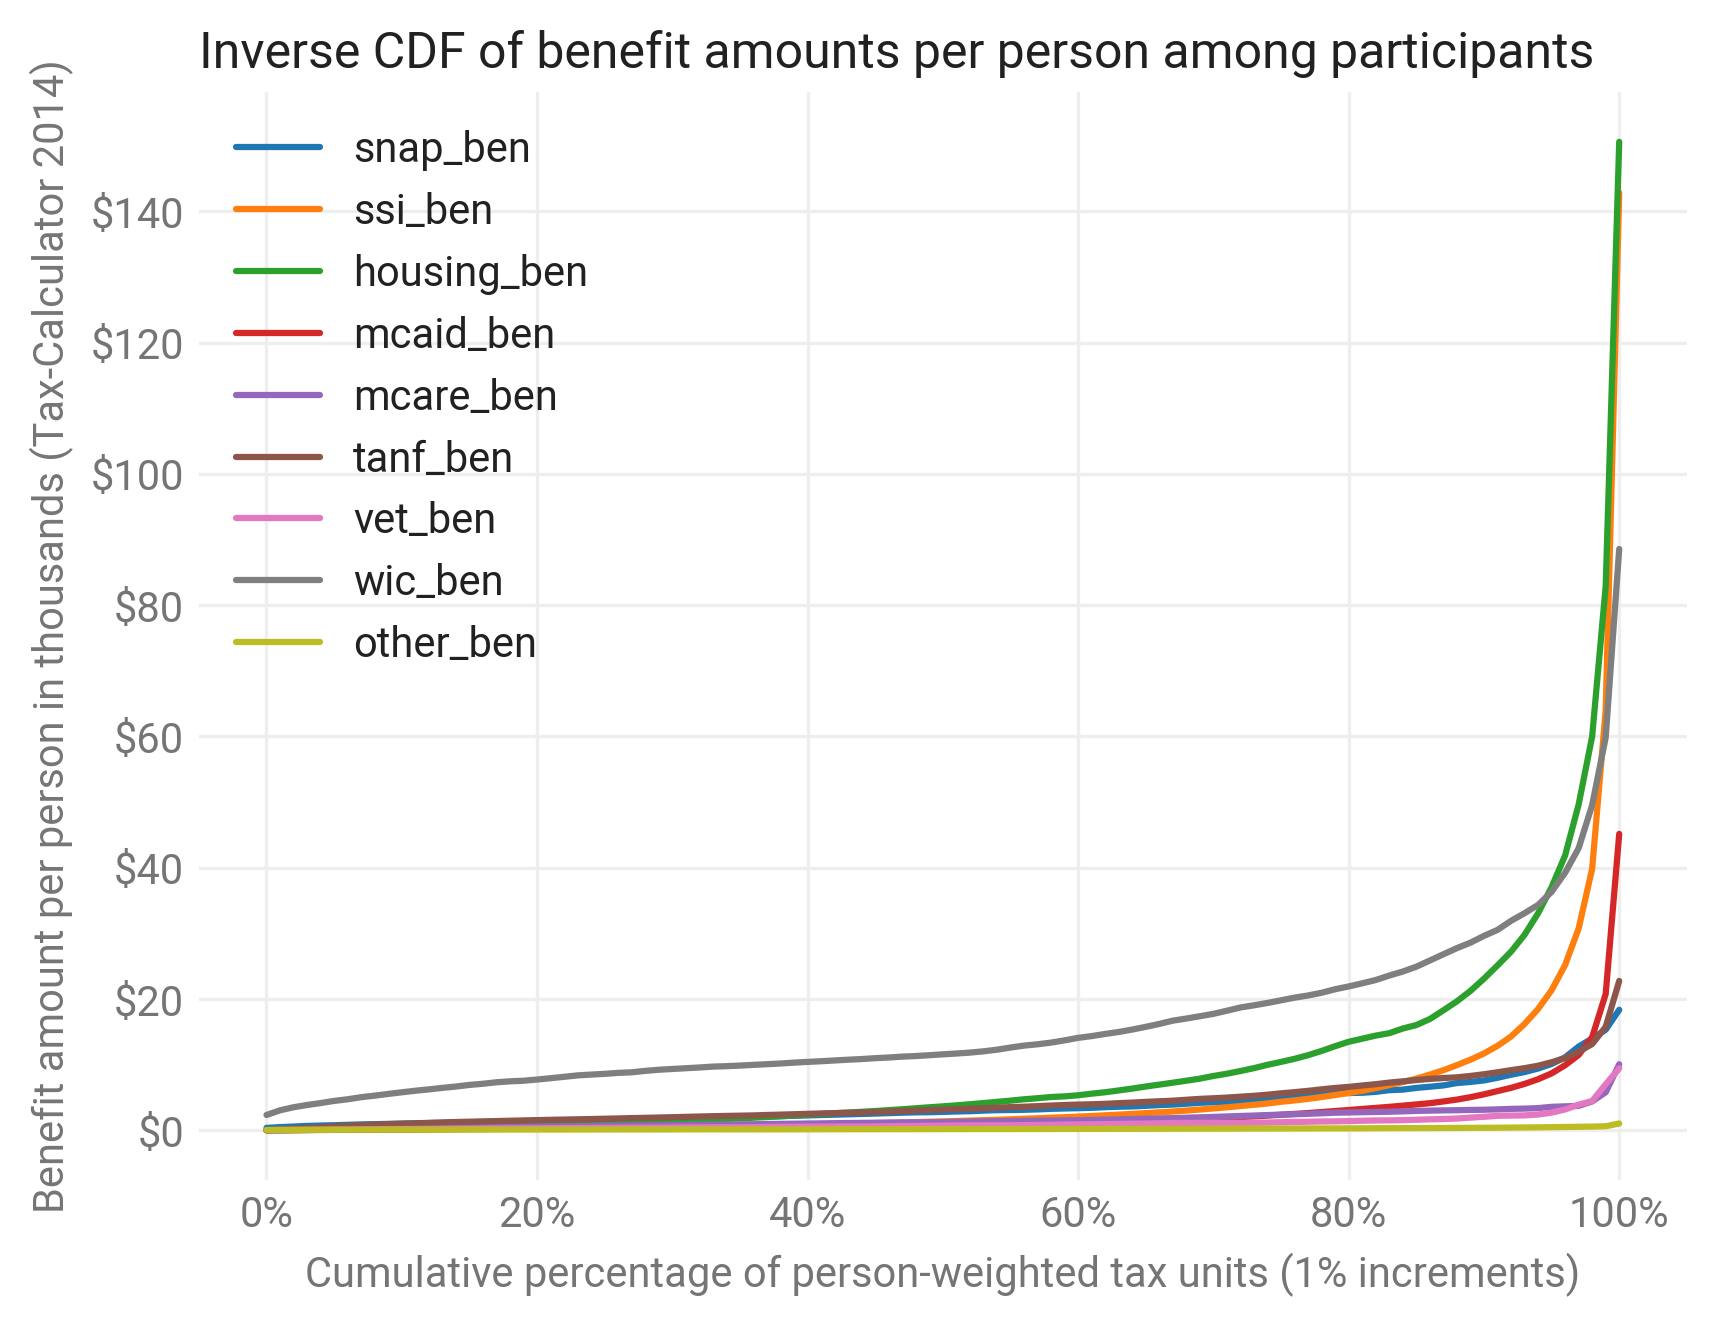

In [104]:
ax = dist.plot()
ax.legend(BENS)
ax.grid(color='#eeeeee')
ax.set(ylabel='Benefit amount per person in thousands (Tax-Calculator 2014)',
       xlabel='Cumulative percentage of person-weighted tax units ' +
       '(1% increments)')
sns.despine(left=True, bottom=True)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x / 1000))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('Inverse CDF of benefit amounts per person among participants', 
          loc='left')
plt.show()

In [110]:
dist_unindex.columns = dist_unindex.columns.droplevel()

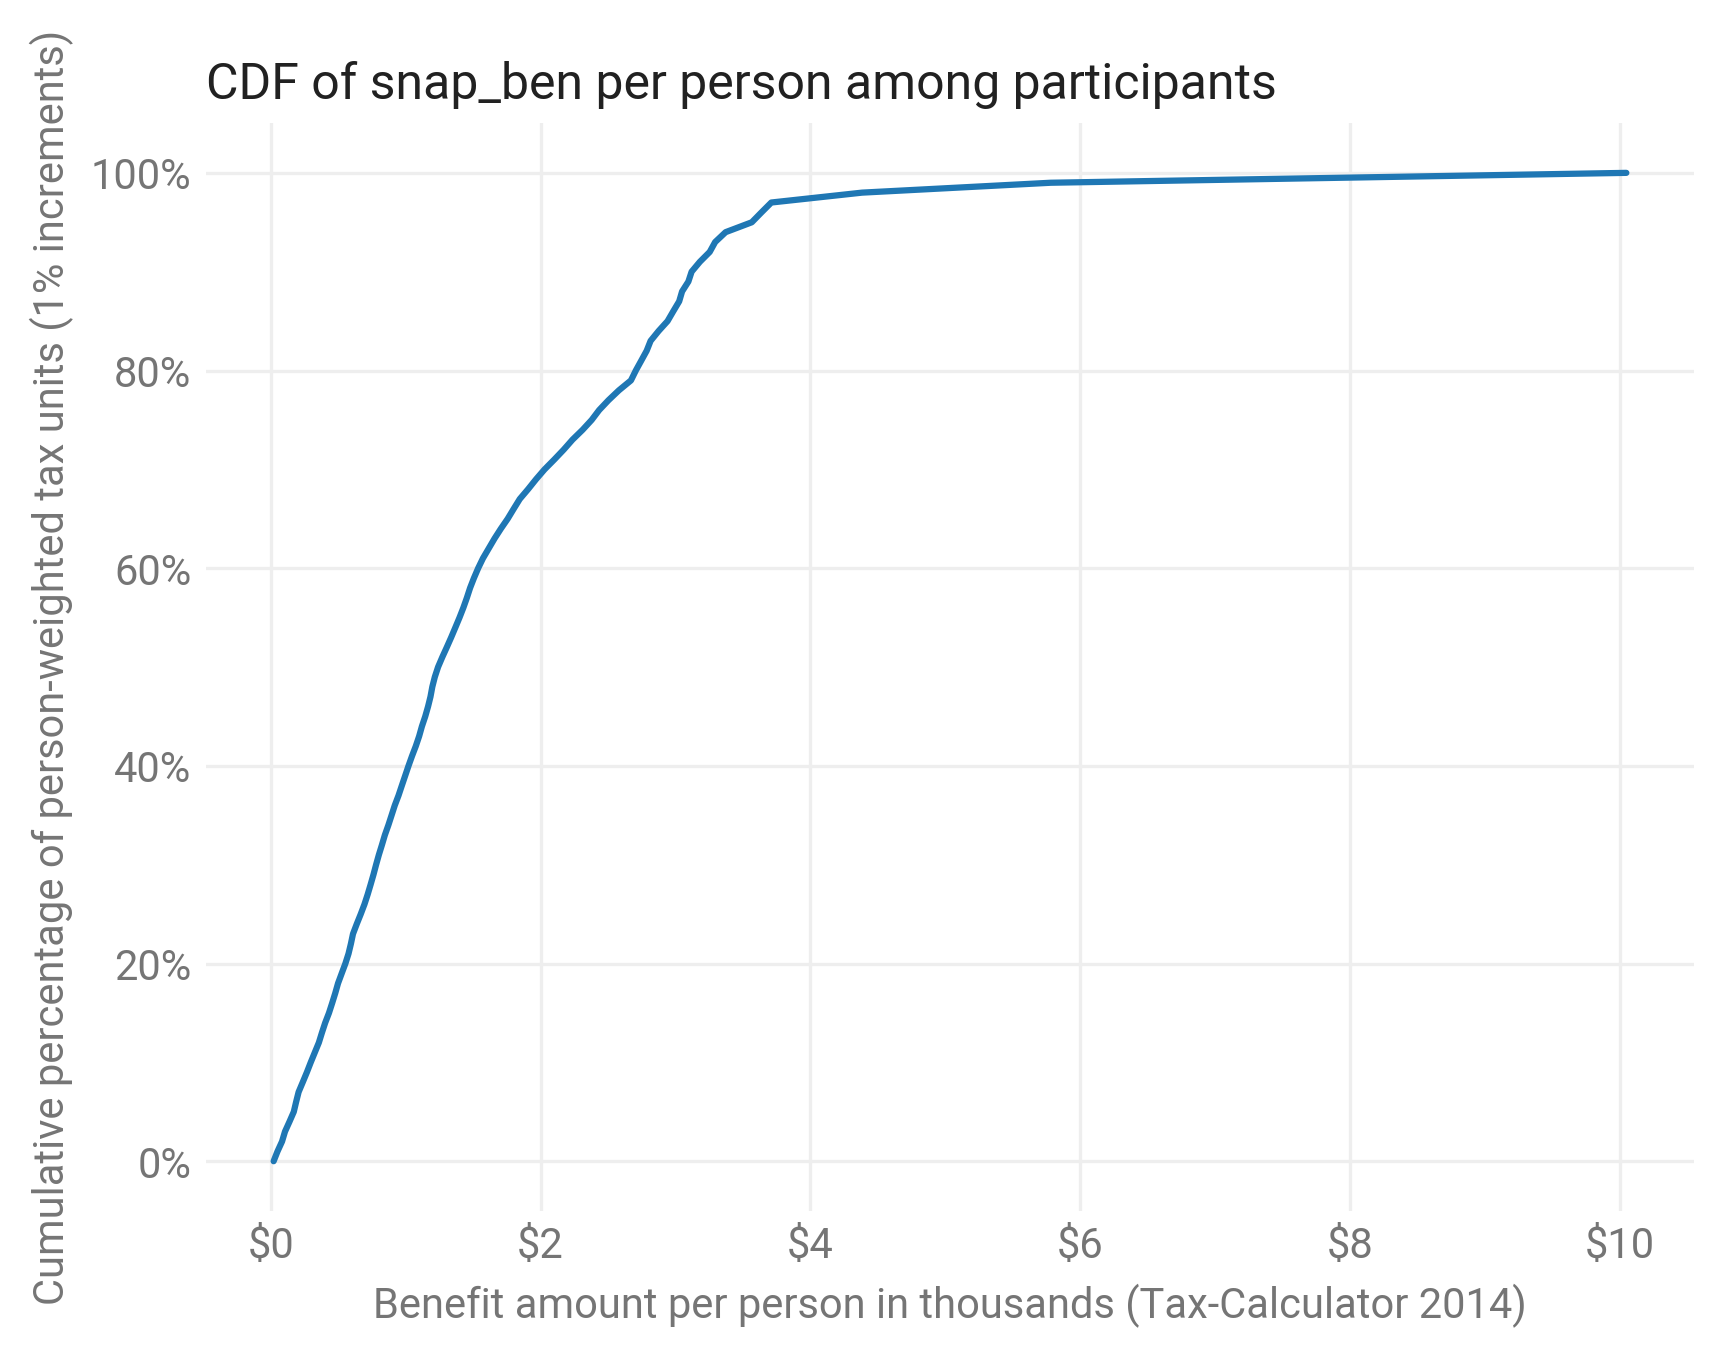

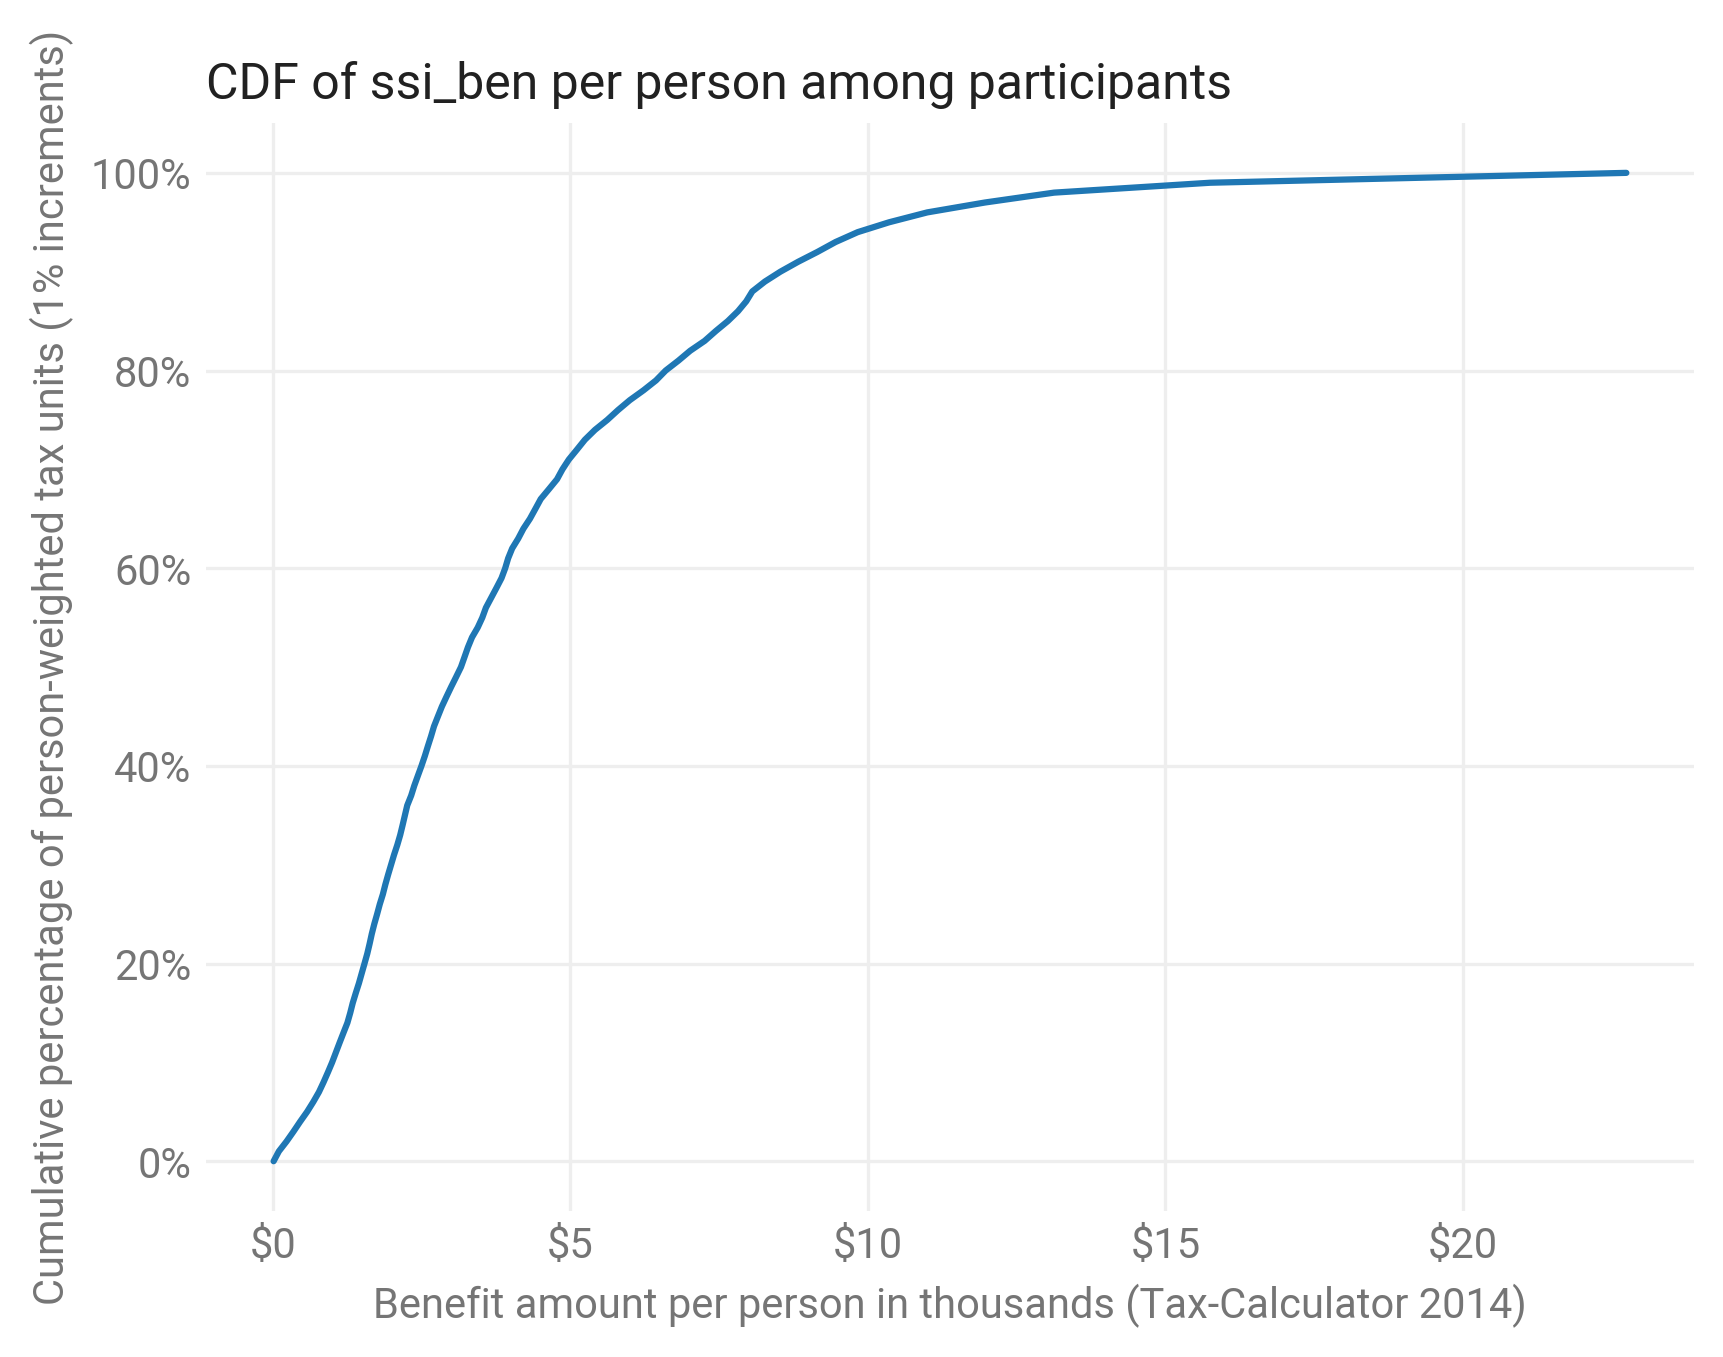

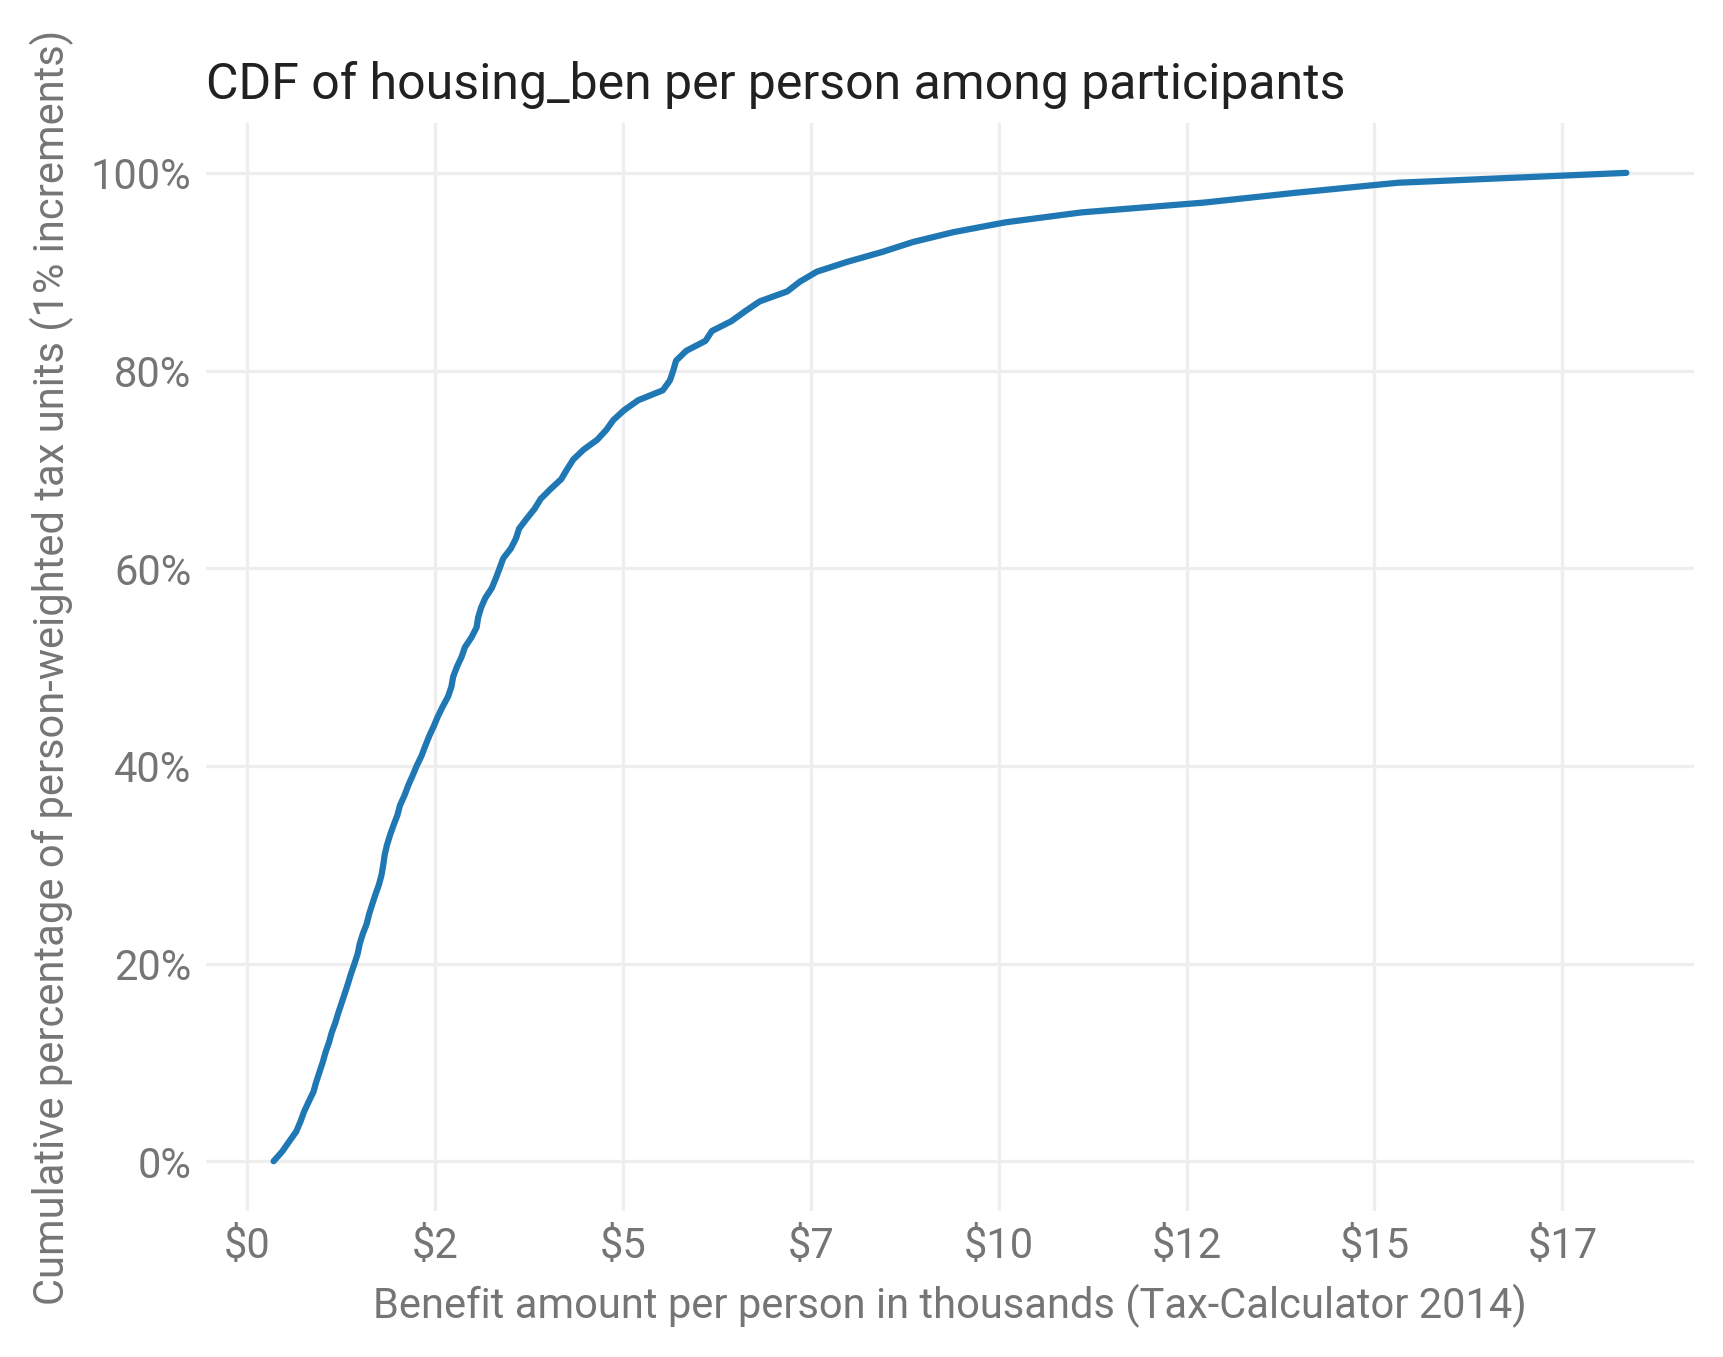

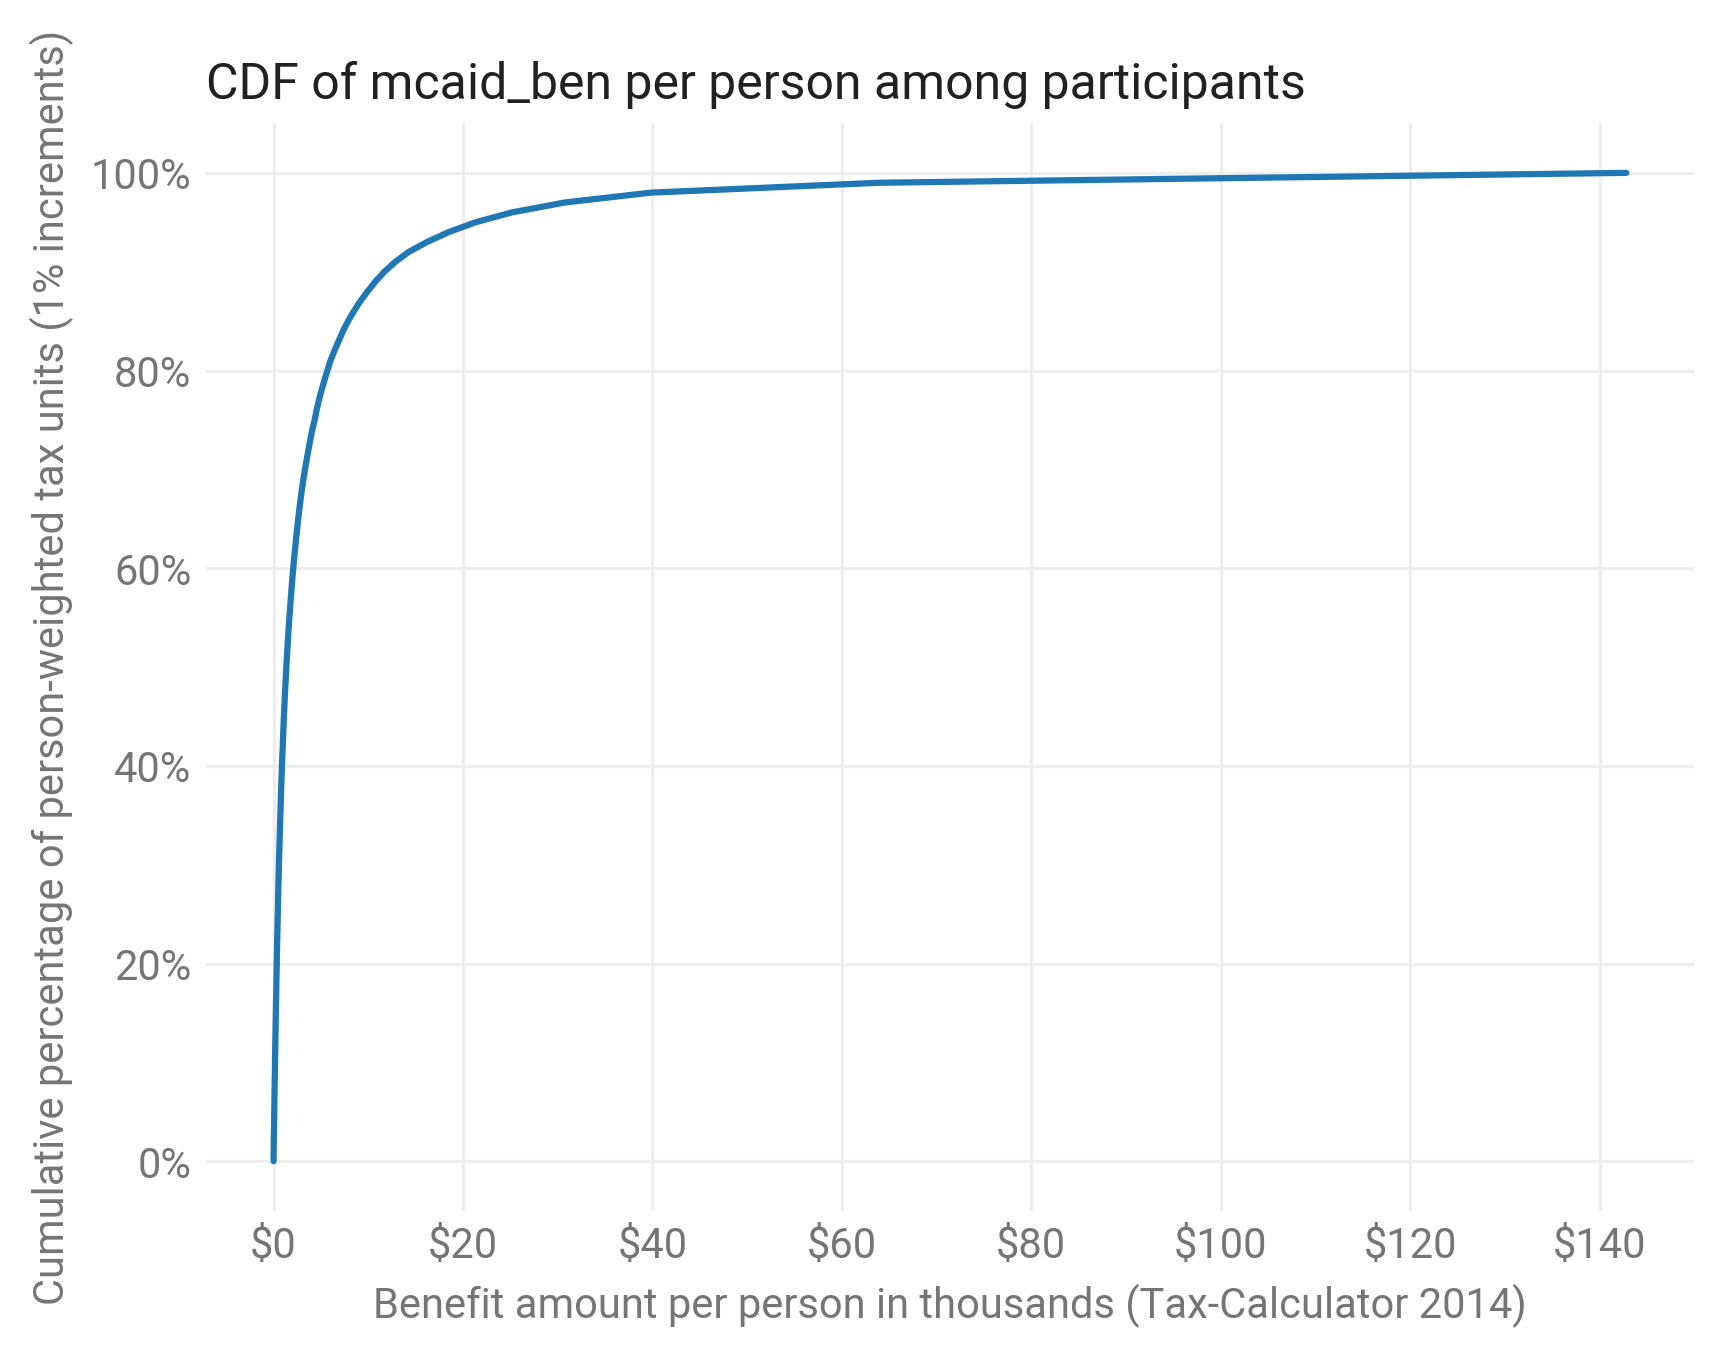

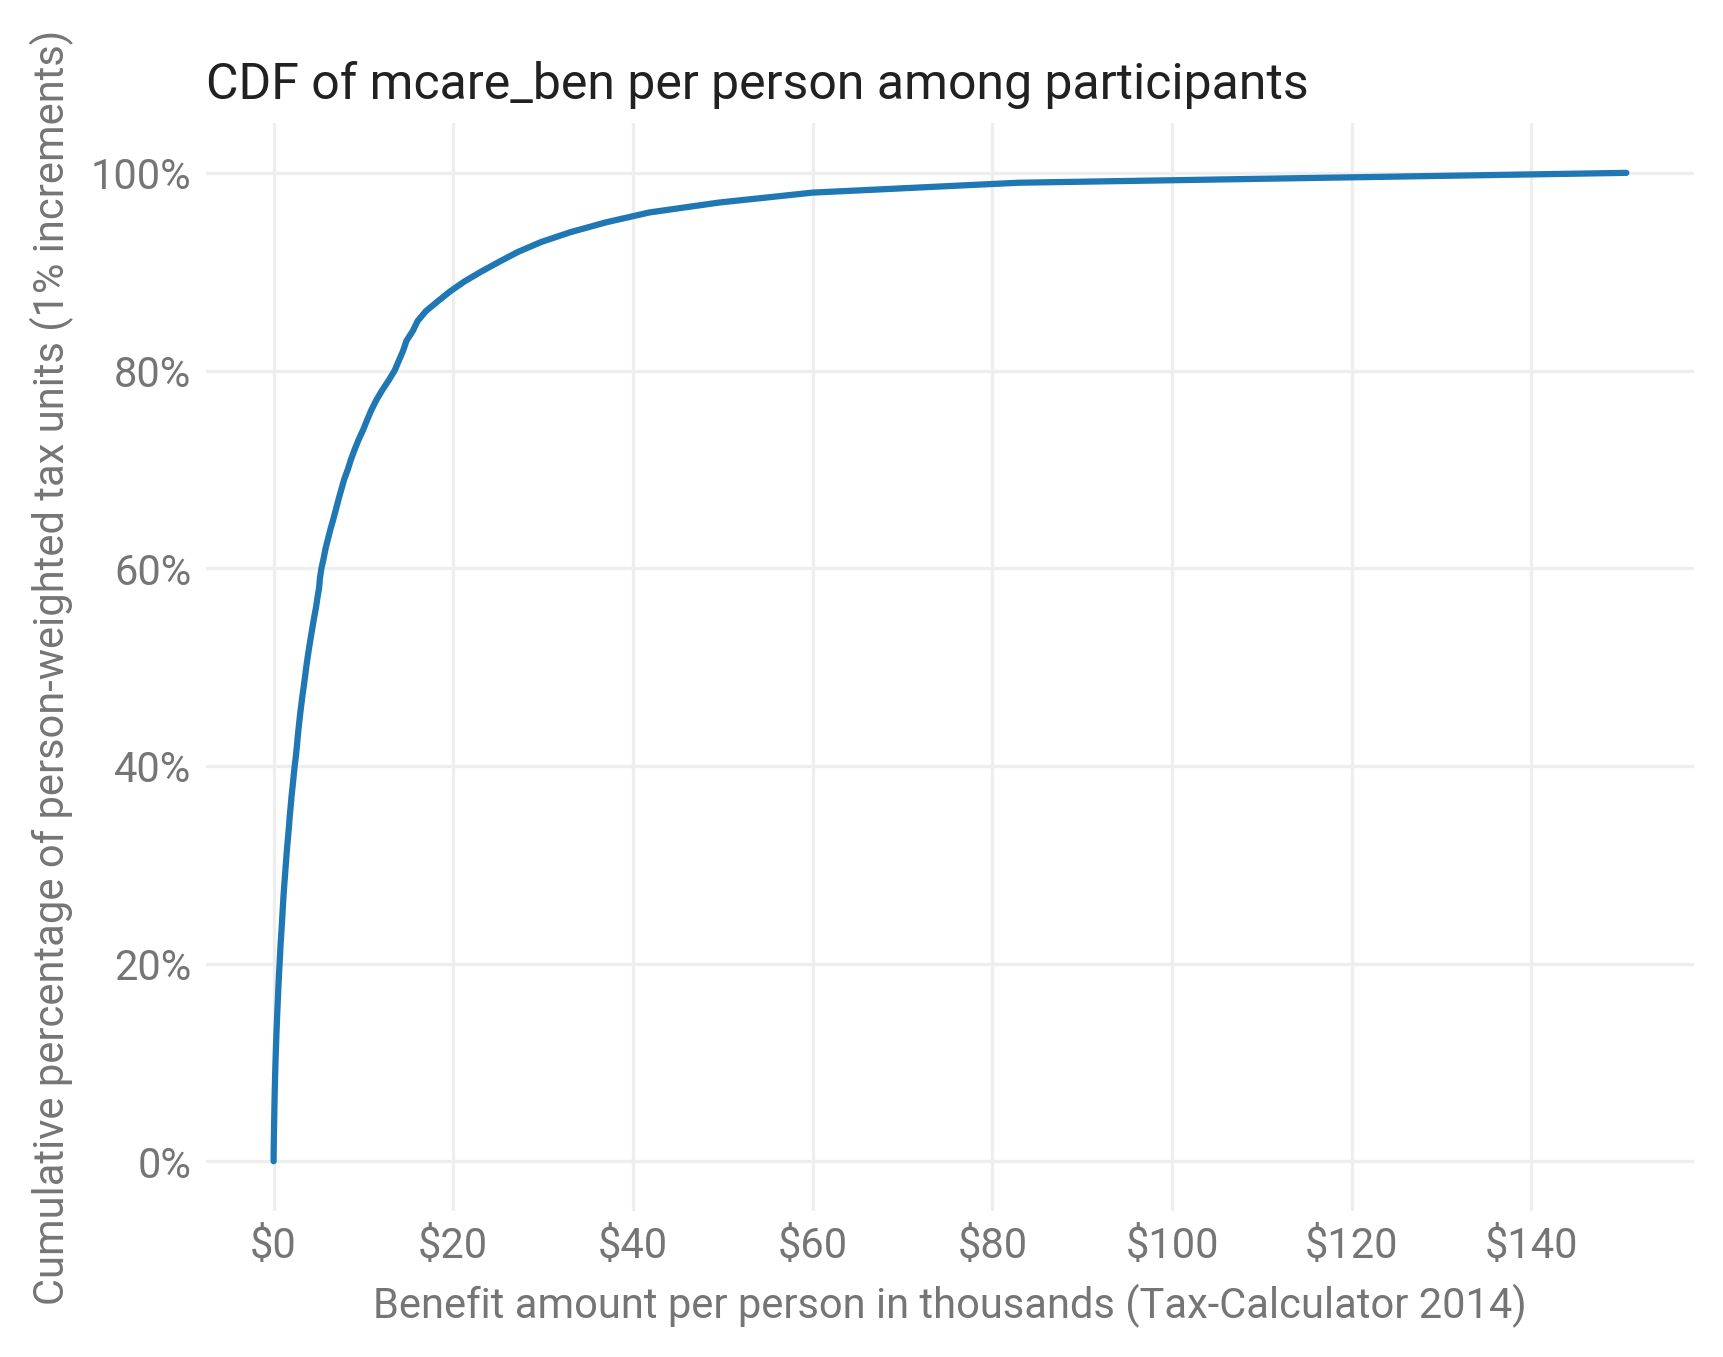

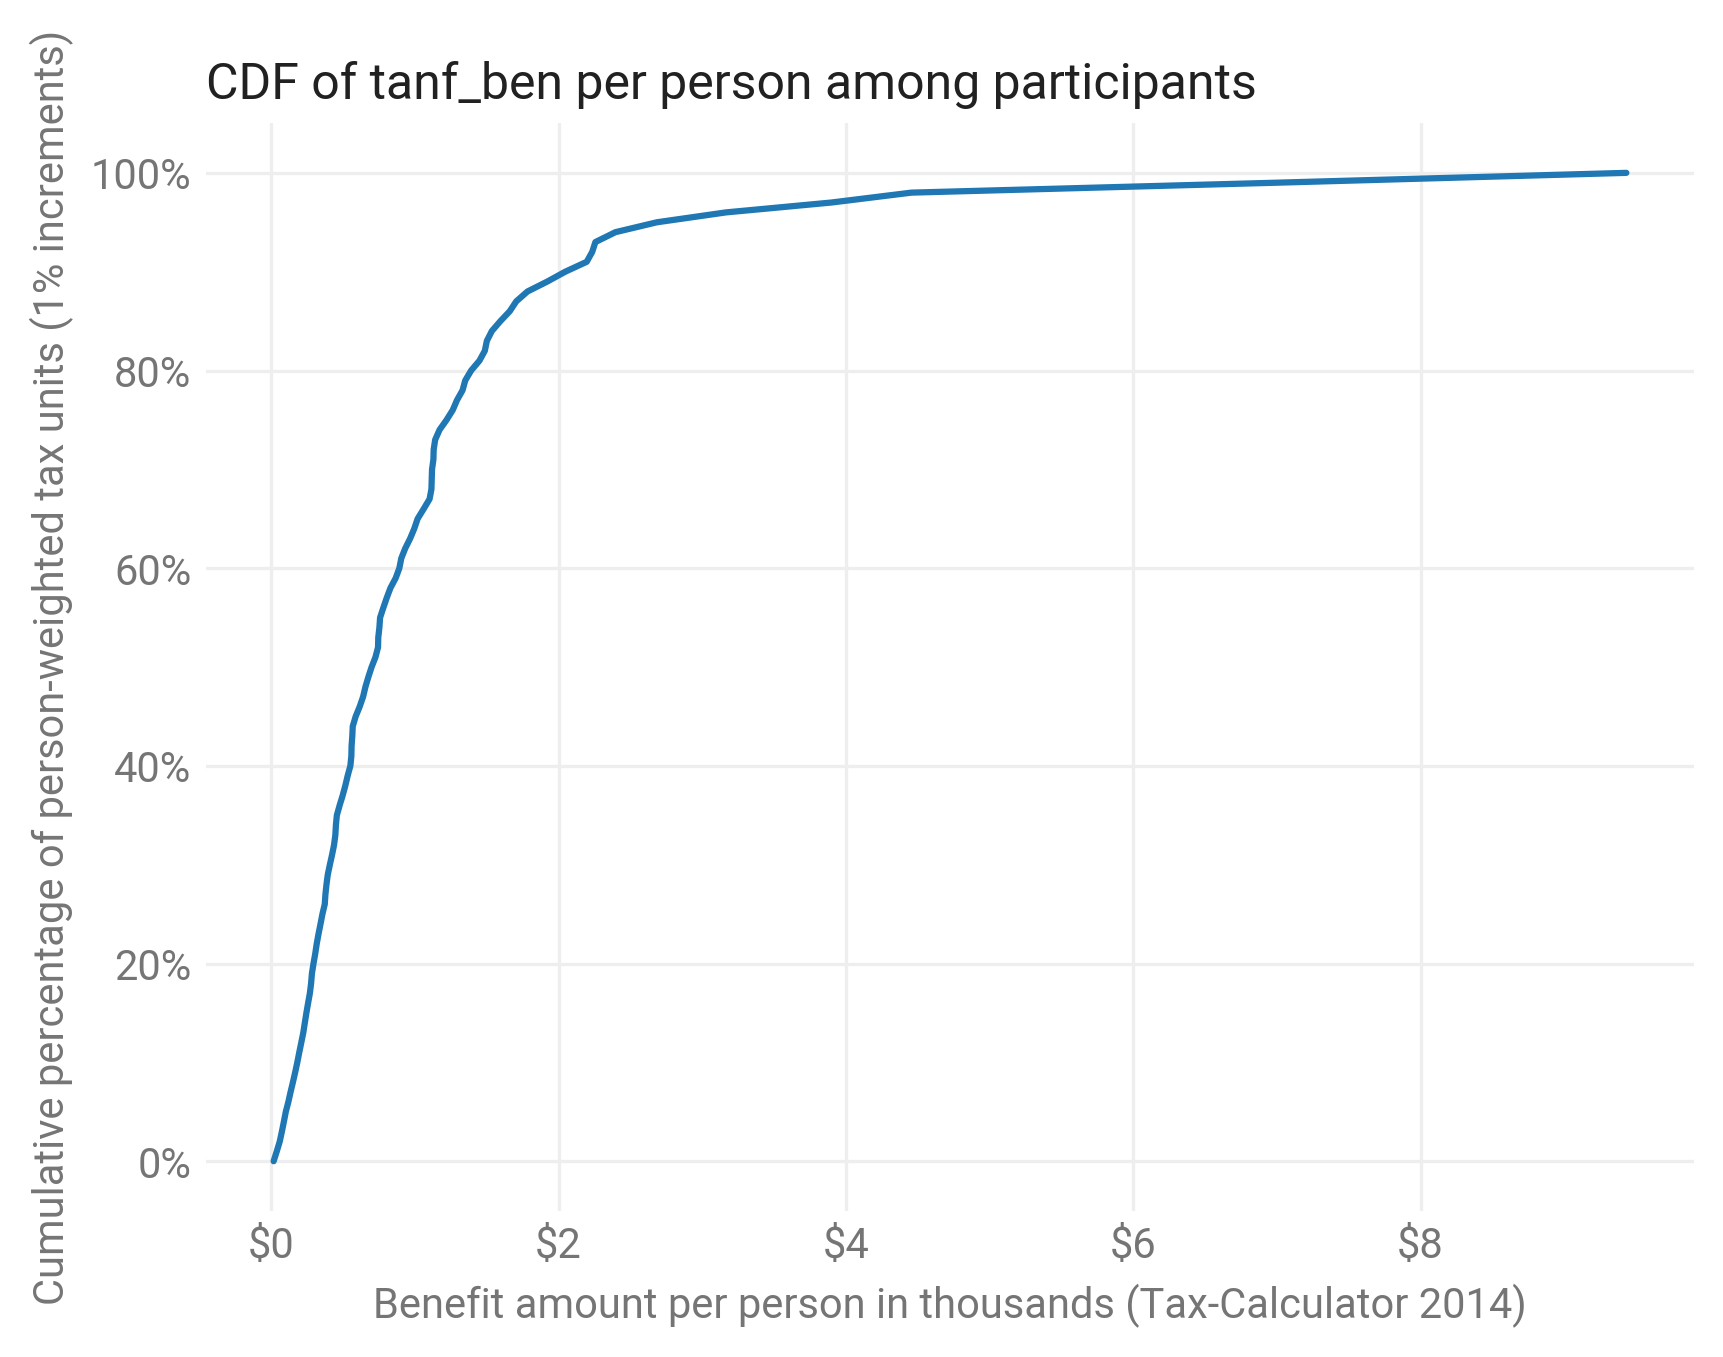

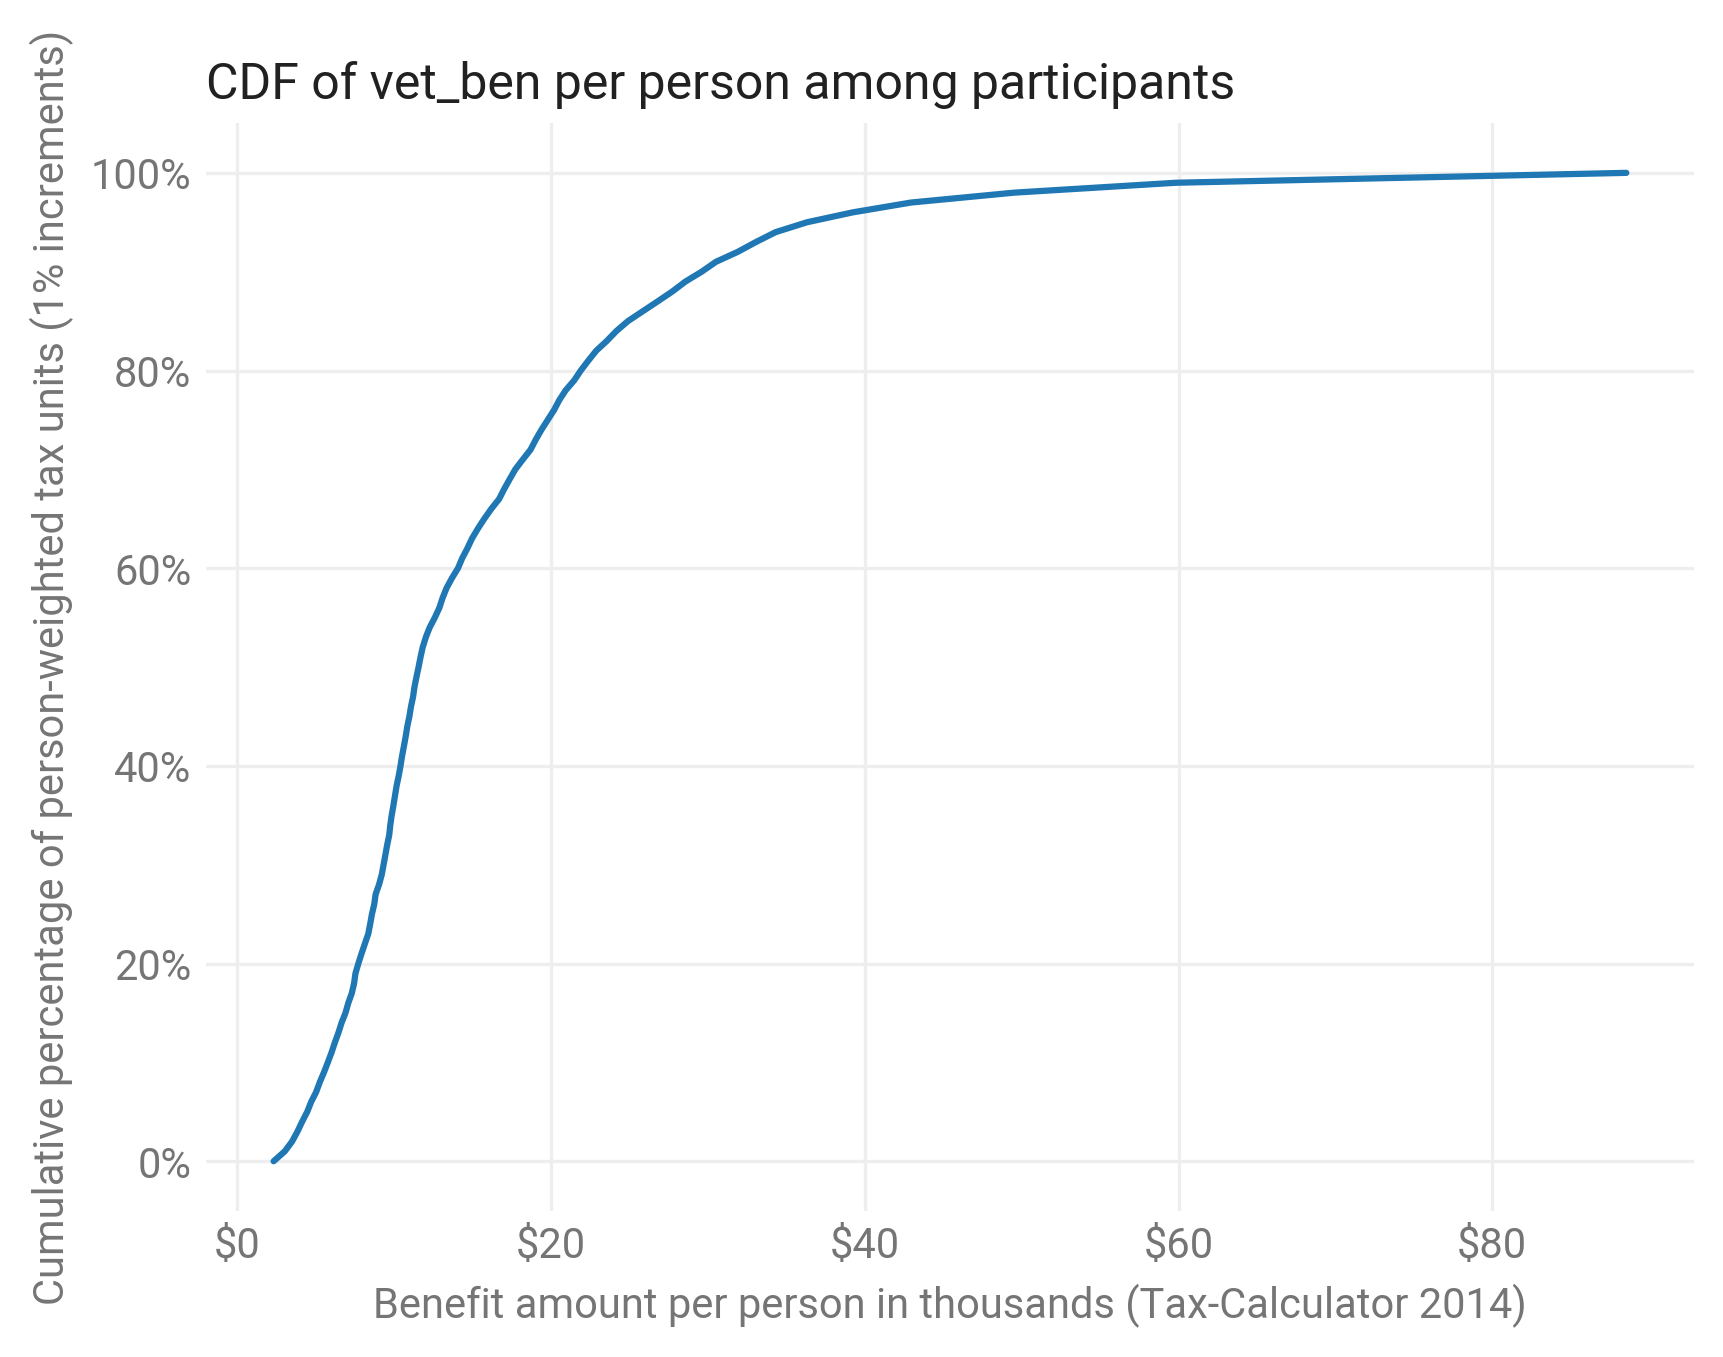

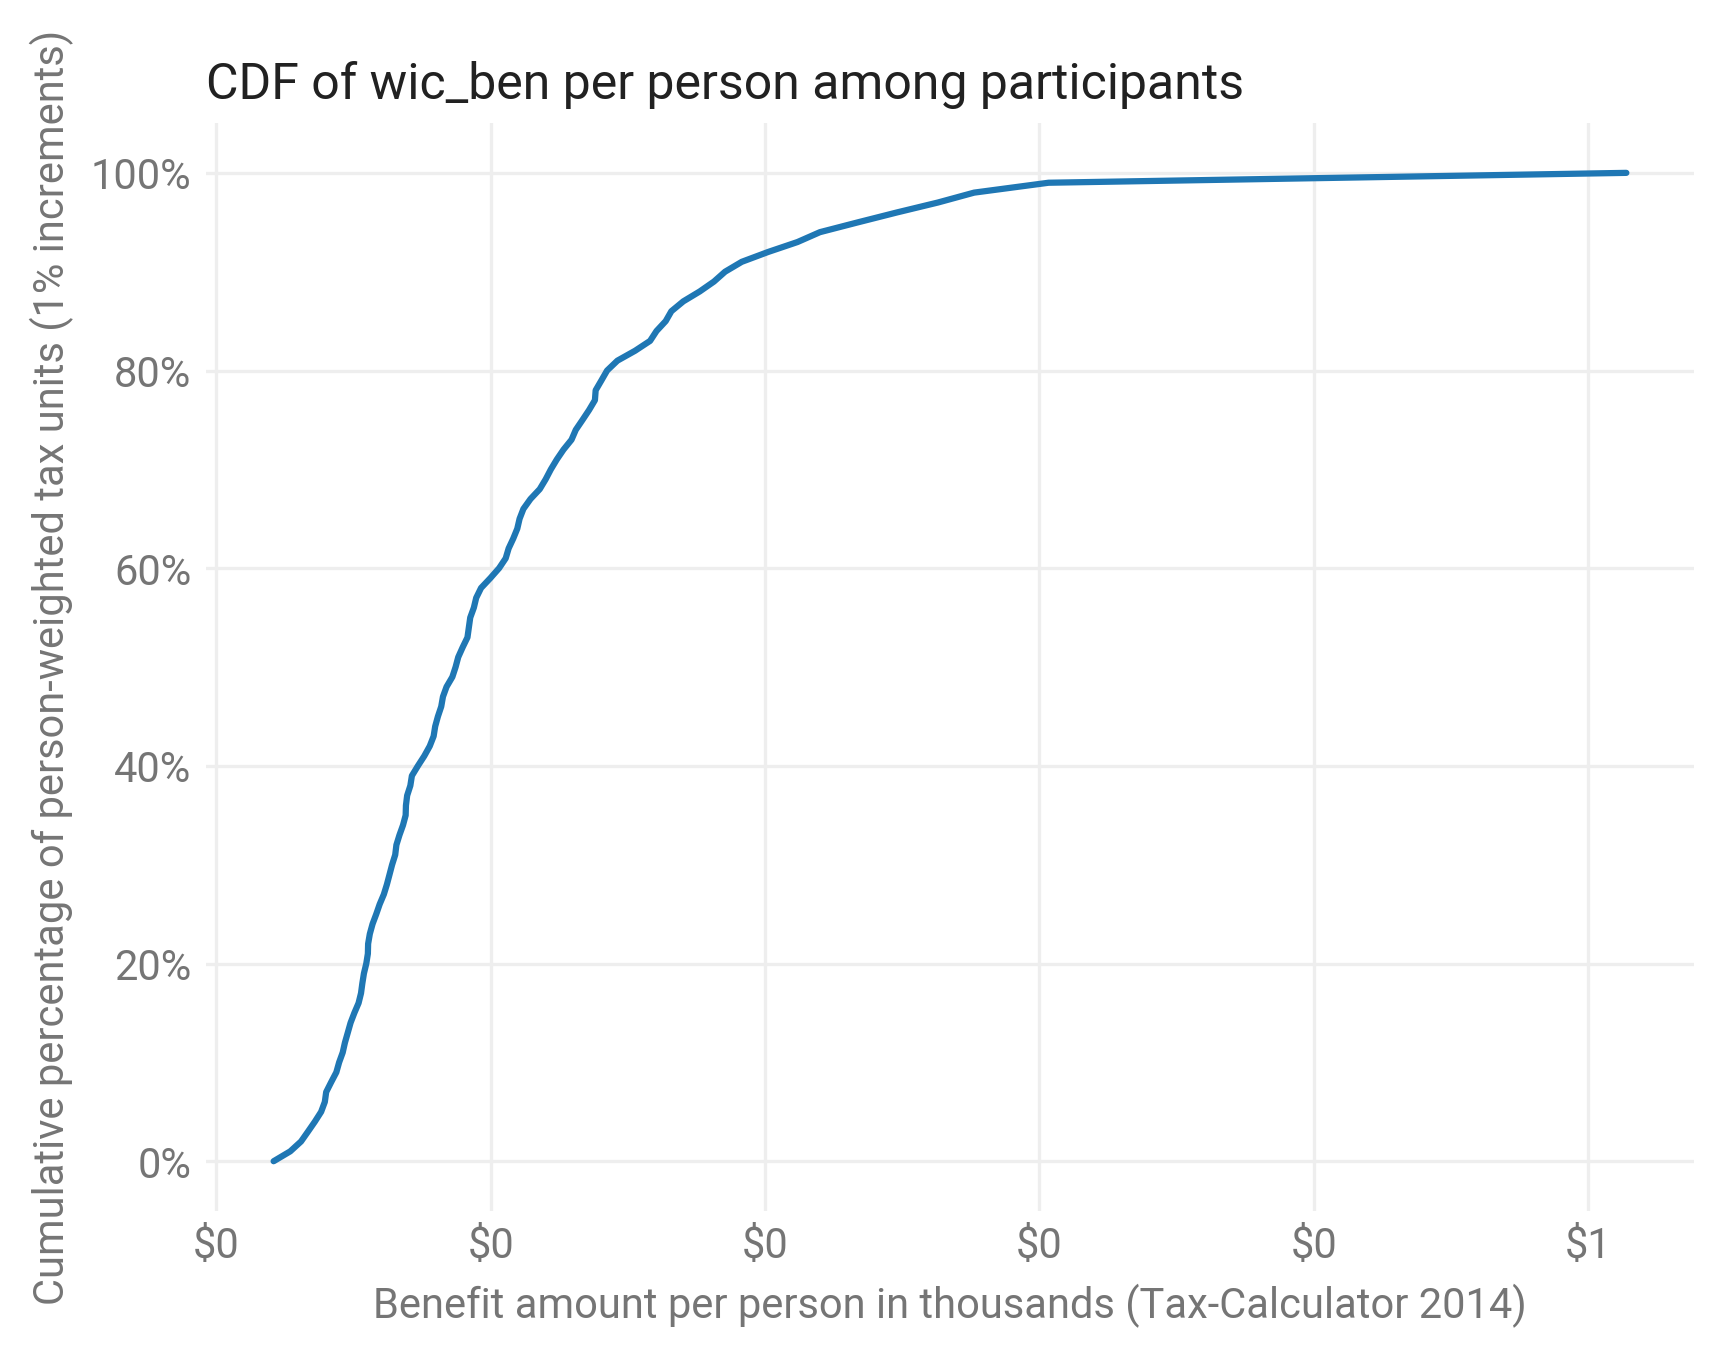

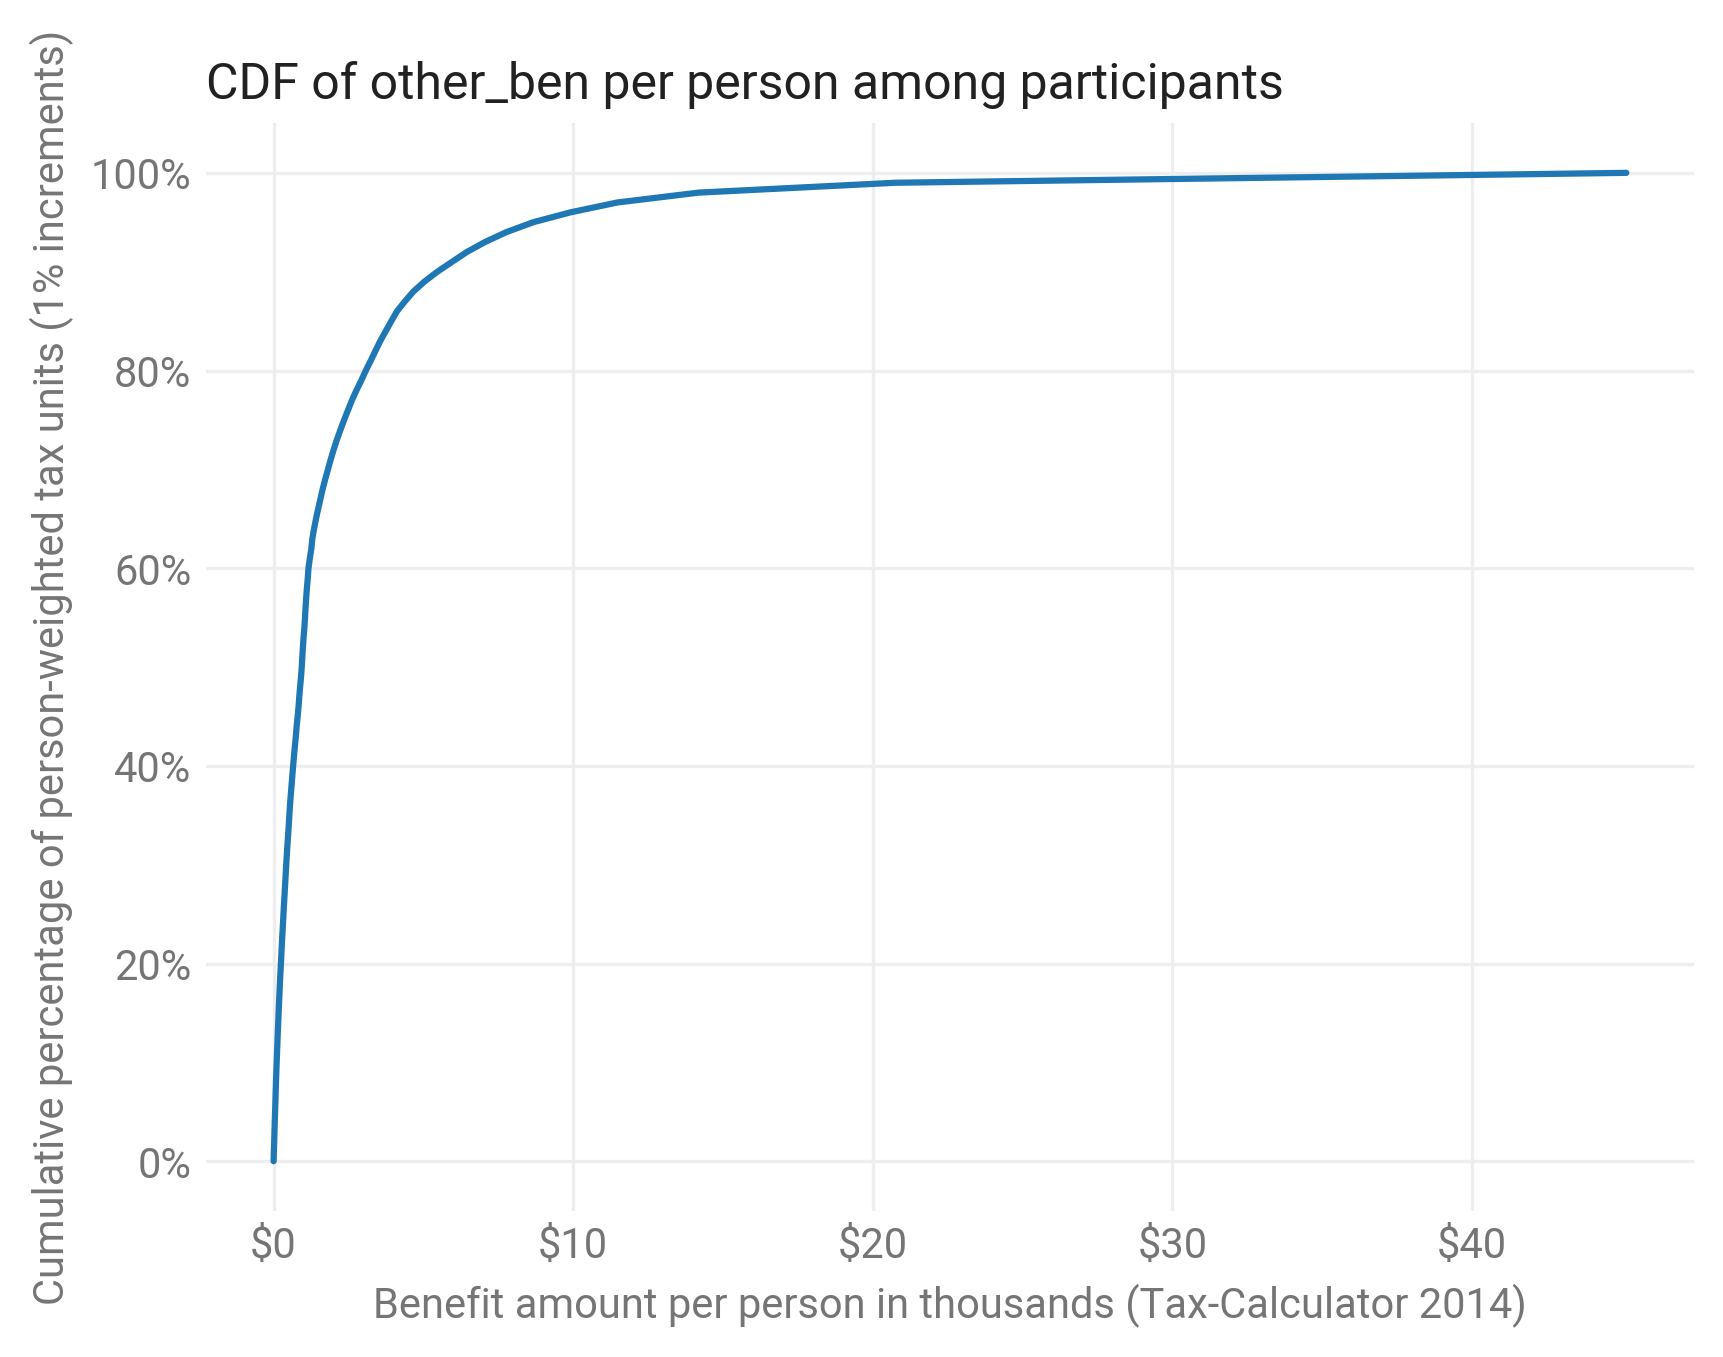

In [117]:
for i in BENS:
    ax = dist_unindex.plot(x=i, y='pctile')
    ax.grid(color='#eeeeee')
    ax.legend_.remove()
    ax.set(xlabel='Benefit amount per person in thousands ' +
           '(Tax-Calculator 2014)',
           ylabel='Cumulative percentage of person-weighted tax units ' +
           '(1% increments)')
    sns.despine(left=True, bottom=True)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda x, _: '$' + format(int(x / 1000))))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y / 100)))
    plt.title('CDF of ' + i + ' per person among participants', 
              loc='left')
    plt.show()